In [1]:
import math
import pickle
from typing import List, Dict, Tuple

import torch
from torchvision.ops import box_iou

from apples_detection.data.minneapple import MinneAppleDetectionModule
from apples_detection.utils.visualize import visualize_apples
from apples_detection.models.components.faster_rcnn import FasterRCNN
from apples_detection.models.minneapple_detection import MinneAppleDetectionLitModule

In [2]:
CKPT_PATH = "/home/dmitry/Desktop/apples-detection/data/models/best_model_27.03.23.ckpt"
PATCHIFIER_PATH = "/home/dmitry/Desktop/apples-detection/data/minneapple-detection/train-patches/patchifier.pkl"

In [3]:
ds_patches = MinneAppleDetectionModule(data_dir="../data/minneapple-detection/", flip=False, use_patches=True)
ds_patches.setup("fit")

ds_full = MinneAppleDetectionModule(data_dir="../data/minneapple-detection/", flip=False, use_patches=False)
ds_full.setup("fit")

In [4]:
net = FasterRCNN()
opt = torch.optim.Adam(params=net.parameters())

model = MinneAppleDetectionLitModule(net, opt).load_from_checkpoint(CKPT_PATH, map_location="cpu", net=net)
_ = model.eval()

In [5]:
with open(PATCHIFIER_PATH, "rb") as f:
    patchifier = pickle.load(f)

patches_shape = (5, 3)
total_patches = math.prod(patches_shape)

In [6]:
def restore_size(
    strides: Tuple[int, int],
    kernel_size: Tuple[int, int],
    patches_shape: Tuple[int, int],
) -> Tuple[int, int]:
    return tuple([patches_shape[j] * strides[j] + kernel_size[j] - strides[j] for j in range(2)])

In [7]:
def merge_patch_detections(
    patchifier,
    detections: List[Dict[str, torch.Tensor]],
    patches_shape: Tuple[int, int],
):
    n_rows, n_cols = patches_shape
    strides_h, strides_w = patchifier.strides
    kernel_h, kernel_w = patchifier.kernel_size
    offsets_h = [i * strides_h for i in range(n_rows)]
    offsets_w = [j * strides_w for j in range(n_cols)]
    
    image_h, image_w = restore_size(patchifier.strides, patchifier.kernel_size, patches_shape)
    
    iou_thres = 0.2

    merged_detections = None
    for row, offset_h in enumerate(offsets_h):
        row_detections = detections[n_cols * row : n_cols * (row + 1)]
        row_merged_detections = None
        for patch_detections, offset_w in zip(row_detections, offsets_w):
            boxes = patch_detections["boxes"]
            if boxes.shape[0] == 0:
                continue

            # bboxes in format [xmin, ymin, xmax, ymax]
            boxes[:, [1, 3]] += offset_h
            boxes[:, [0, 2]] += offset_w
            print(boxes)
            
            
        
        break
#             target = torch.zeros(row_patch.shape[0], kernel_h, image_w)
#             target[:, :, offset_w : offset_w + kernel_w] = row_patch
#             if masks is None:
#                 masks = target.clone().type(torch.ByteTensor)
#                 continue

#             pairwise_iou = box_iou(
#                 masks_to_boxes(masks), masks_to_boxes(target.type(torch.ByteTensor))
#             )

#             to_merge = torch.argwhere(pairwise_iou > iou_thres)
#             not_to_merge = torch.argwhere(
#                 pairwise_iou.max(dim=0).values <= iou_thres
#             ).unique()

#             for existing_idx, merge_idx in to_merge:
#                 masks[existing_idx, :, :] = masks[existing_idx, :, :].logical_or(
#                     target[merge_idx, :, :]
#                 )

#             if len(not_to_merge) > 0:
#                 masks = torch.cat([masks, target[not_to_merge, :, :]], axis=0).type(
#                     torch.ByteTensor
#                 )

#             del target
        
        
    return 

tensor([[139.0505, 145.4693, 157.7999, 169.8747],
        [115.3299, 225.1402, 134.5173, 240.7210],
        [173.4111, 168.3913, 190.4120, 187.6182],
        [242.3271, 214.6649, 255.4099, 230.4611]], grad_fn=<StackBackward0>)
tensor([[139.0505, 145.4693, 157.7999, 169.8747],
        [115.3299, 225.1402, 134.5173, 240.7210],
        [173.4111, 168.3913, 190.4120, 187.6182],
        [242.3271, 214.6649, 255.4099, 230.4611]], grad_fn=<CopySlices>)
tensor([[228.7348, 227.2882, 254.1451, 255.7292],
        [239.7094, 233.1451, 254.7274, 256.0000]], grad_fn=<StackBackward0>)
tensor([[692.7348, 227.2882, 718.1451, 255.7292],
        [703.7094, 233.1451, 718.7274, 256.0000]], grad_fn=<CopySlices>)


/home/dmitry/.cache/pypoetry/virtualenvs/apples-detection-SzWlg4Ph-py3.8/lib/python3.8/site-packages/torchvision/utils.py:210: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


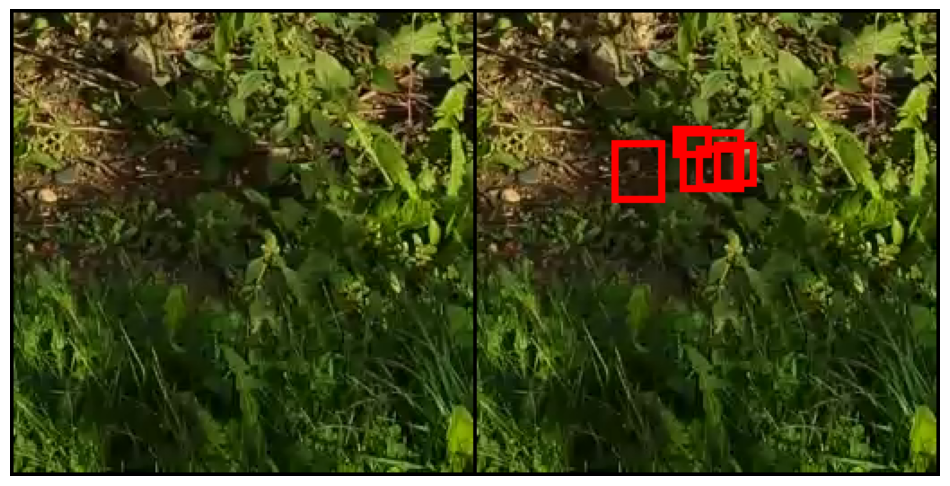

In [8]:
merged_detections: List[Dict[str, torch.Tensor]] = []

patches_data: List[Dict[str, torch.Tensor]] = []
for i, (image, target) in enumerate(ds_patches.data_val):
    [pred] = net(image.unsqueeze(0))
    patches_data.append(pred)

    if len(patches_data) == total_patches:
        merged_target = merge_patch_detections(patchifier, patches_data, patches_shape)
        patches_data.clear()
        merged_detections.append(merged_target)
        visualize_apples([(image, target), (image, pred)], confidence_threshold=0.0, nrow=3)
        break

# merged_detections

In [ ]:
patches = [image for image, _ in ds_patches.data_val]

In [ ]:
for i in range(16):
    print(ds_patches.data_val.get_img_name(i))

In [ ]:
for i in range(15):
    image, target = ds_patches.data_val[i]
    [pred] = model(image.unsqueeze(0))
    data = [(image, {}), (image, target), (image, pred)]
    visualize_apples(data, nrow=3)